In [ ]:
import pandas as pd
import numpy as np

# Наивный байесовский классификатор



*   Теорема позволяет найти вероятность того, что именно эта причина привела к наблюдаемому событию



<h1 align="center"> $ P(A|B) = \frac{ P(B|A)P(A) }{ P(B) } $ </h1>


* $ P(A|B) $ — вероятность того, что событие $А$ истинно, если событие $B$ истинно
* $ P(B|A) $ — вероятность того, что событие $B$ истинно, если событие $A$ истинно
* $ P(A) $ — вероятность того, что событие $А$ истинно
* $ P(B) $ — вероятность того, что событие $B$ истинно

----

#### Подготовка данных

In [ ]:
from keras.datasets import imdb
import keras

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

17464789/17464789 [==============================] - 1s 0us/step


In [ ]:
x_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [ ]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
def decode_review(sample):
    NUM_WORDS=None
    INDEX_FROM=3   # откуда индексирем

    train,test = keras.datasets.imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)

    word_to_id = keras.datasets.imdb.get_word_index()
    word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2
    word_to_id["<UNUSED>"] = 3

    id_to_word = {value:key for key,value in word_to_id.items()}

    return ' '.join(id_to_word[id] for id in sample)

In [ ]:
print(decode_review(x_train[0]))
print(y_train[0])

1641221/1641221 [==============================] - 1s 0us/step
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big pr

In [ ]:
print(decode_review(x_train[20]))
print(y_train[20])

<START> shown in australia as 'hydrosphere' this incredibly bad movie is so bad that you become hypnotised and have to watch it to the end just to see if it could get any worse and it does the storyline is so predictable it seems written by a high school dramatics class the sets are pathetic but marginally better than the miniatures and the acting is wooden br br the infant 'muppet' seems to have been stolen from the props cupboard of 'total recall' there didn't seem to be a single original idea in the whole movie br br i found this movie to be so bad that i laughed most of the way through br br malcolm mcdowell should hang his head in shame he obviously needed the money
0


----

#### Создание алгоритма и обучение

collections.defaultdict ничем не отличается от обычного словаря за исключением того, что по умолчанию всегда вызывается функция, возвращающая значение:

In [ ]:
import collections

defdict = collections.defaultdict(list)
print(defdict)

for i in range(5):
    defdict[i] = i

print(defdict)

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4})


Пусть у нас есть строка текста $O$. Кроме того, имеются классы $С$, к одному из которых мы должны отнести строку. Нам необходимо найти такой класс с, при котором его вероятность для данной строки была бы максимальна. Найдем этот класс как

<h4 align="center"> $ С = argmax_c P(C|O) $ </h4>


$argmax_x f(x)$ есть значение $x$, при котором $f(x)$ максимальна




Т.к. получить $P(C|O)$ сложно легче вычислить косвенные вероятности используя теорему Байеса:

<h4 align="center"> $ P(C|O) = \frac{ P(O|C)P(C) }{ P(O) } $ </h4>


Так как мы ищем максимум от функции, то знаменатель нас не интересует (он в данном случае константа). Кроме того, нужно взглянуть на строку O. Обычно, нет смысла работать со всей строкой. Намного эффективней выделить из нее определенные признаки (features). Таким образом формула примет вид:

<h4 align="center"> $ P(C|O) = \frac{ P(o_1, o_2, ... , o_n)P(C) }{ P(o_1, o_2, ... , o_n) } $ </h4>

Используем «наивное» предположение о том, что переменные O зависят только от класса C, и не зависят друг от друга. Это сильно упрощение, но зачастую это работает. Числитель примет вид:

(Числитель эквивалентен совместной вероятности модели, переписываем используя повторные приложения определений условной вероятности)

<h4 align="center"> $P(C)P(o_1|C)P(o_2|C_{o1})...P(o_n|C_{o1o2...on})$ </h4>


In [ ]:
from collections import defaultdict
from math import log

def train(samples):
    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in samples:
        # находим лэйбл класса и считаем его частоту
        classes[label] += 1
        # feats - элемент обучающей выборки, наш обзор
        # [1, 14, 22, 16, 43, ... <- закодированные в словаре наборы слов
        for feat in feats:
            # проходимся по всем словам и считаем их частоты (кол-во элементов)
            # ключ - (лейбл, слово) (пример (0, 11176): 26 )
            freq[label, feat] += 1          # count features frequencies

    # внутри freq содержится записи формата (лейбл(1 или 0 в нашем случае), слово(133)) : кол-во встречаний в тексте
    # нормализуем частоты фичей и классов
    # распаковываем лейбл и фичу из частот, делим на кол-во элементов этого класса
    for label, feat in freq:
        freq[label, feat] /= classes[label] # для получения частоты нормируем на кол-во элементов в классе

    # кол-во элементов для каждого класса делим на кол-во семплов
    for c in classes:
        classes[c] /= len(samples)

    # мы получили classes - соответсвует вероятности P(C)
    # и freq - вероятности P(O|C)
    return classes, freq

В функции train первые пять строк производят подсчет количества классов C, а также частоту появления фич O и С в одном семпле. Вторая часть метода просто нормирует эти частоты. Таким образом на выходе получаются вероятности $P(C)$ и $P(O|C)$.

In [ ]:
def classify(classifier, feats):
    classes, prob = classifier
    '''
    print(classes)
    print(prob)

    print(-log(classes[0]) + sum(-log(prob.get((0,feat), 10**(-7))) for feat in feats) )
    print(-log(classes[1]) + sum(-log(prob.get((1,feat), 10**(-7))) for feat in feats) )
    '''
    # max ( P(1|O), P(0|O))

    # argmin(-log(C|O))
    return min(classes.keys(),
        key = lambda cl: -log(classes[cl]) + sum(-log(prob.get((cl,feat), 10**(-7))) for feat in feats) )

В функции classify происходит поиск наиболее вероятного класса. Тут заменяется произведение вероятностей на сумму логарифмов, взятых с отрицательным знаком, и вычисляю не argmax, а argmin. Переход к логарифмам — распространненный прием чтобы избежать слишком маленьких чисел, которые могли бы получится при произведении вероятностей + логарифм – монотонно возрастающая функция. Логарифм от функции достигнет максимума в той же точке (по оси абсцисс), что и сама функция.
Число 10(^-7), которое подставляется в логарифм, это способ избежать нуля в аргументе логарифма (т.к. он будет иначе он будет неопределен).

формат 1 элемента обучающей выборки
([1, 2, 3, 123, ... <- слова], 1 <-ответ)

обучающая выборка [(), (), () ]

In [ ]:
features = [(x_train[i], y_train[i]) for i in range(len(x_train))]

In [ ]:
classifier = train(features)

----

#### Проверка

Проверим как работает на примере позитивного обзора

In [ ]:
decode_review(x_test[11])

"<START> when i first saw this movie in the theater i was so angry it completely blew in my opinion i didn't see it for a decade then decided what the hell let's see i'm watching all hellraiser movies now to see where it went wrong my guess is it was with sequel 5 that was the first to implement the whole i am in a dream omg i see weird stuff oh noes what is happening oh its a dream oh its not a dream oh wait i see something spooky oh never mind sucky storyline those sequels don't even require the box to be opened or stick to the rules from the first 4 movies that if you saw pinhead you are pretty much screwed and dead the first 3 sticked to this storyline which made it so scary in the first place nothing fantasy nothing weird the box got opened boom they came was the only one that could bargain her way out of it first because of uncle frank then because she had information about the this movie at least attempts to stick to all that even though it was a bad story it was still somewhat 

In [ ]:
print('true label', y_test[11])

true label 0


In [ ]:
print('predicted', classify(classifier, (x_test[11])) )

predicted 0


Посмотрим на пример негативного обзора

In [ ]:
decode_review(x_test[30])

"<START> tim robbins did a masterful job directing this film i say this because he avoided convention and cliché he also oversaw superb performances from susan sarandon who won an oscar for her role and sean penn even more amazing robbins doesn't patronize he just tells the story and lets the events play on the viewer's mind this is so effective because it allows the viewer to form his own opinions on the death penalty one of the most controversial subjects of our time without being unfairly manipulated in either direction i can't recommend this film enough 9 10"

In [ ]:
print('true label', y_test[30])

true label 1


In [ ]:
print('predicted', classify(classifier, (x_test[30])) )

predicted 1


----

Надо проверить все это на метриках качества

In [ ]:
from sklearn.metrics import classification_report

predicted = [classify(classifier, (x_test[i])) for i in range(len(x_test))]

In [ ]:
predicted[:5]

[0, 1, 1, 0, 1]

In [ ]:
y_test[:5]

array([0, 1, 1, 0, 1])

In [ ]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     12500
           1       0.79      0.79      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



----

# Модификации и реализации Наивного Байеса

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB

## Multinomial Naive Bayes

Полиномиальный наивный байесовский классификатор подходит для классификации с дискретными признаками (например, количество слов для классификации текста). Полиномиальное распределение обычно требует целочисленного количества признаков. Однако, на практике, дробные, такие как tf-idf, также могут работать.


Оригинальный алгоритм:

$$p(f_1,..., f_n|c) = \prod_{i=1}^n p(f_i|c)$$

До этого момента мы ничего не говорили о распределении каждого признака. Другими словами, мы оставили $p(fi | c)$ неопределенным. Термин «Полиномиальный наивный байесовский» просто дает нам знать, что каждый $p (fi | c)$ является многочленным распределением, а не каким-либо другим распределением. Это хорошо работает для данных, которые можно легко преобразовать в счетчики, например, слова в тексте.

Наивный байесовский классификатор является общим термином, который относится к условной независимости каждой из функций в модели, в то время как полиномиальный наивный байесовский классификатор является конкретным экземпляром наивного байесовского классификатора, который использует полиномиальное распределение для каждой из функций.

MultinomialNB реализует наивный алгоритм Байеса для полиномиально распределенных данных и является одним из двух классических наивных байесовских вариантов, используемых в классификации текста (где данные обычно представлены в виде вектора количества слов из всех слов, или как tf-idf). Распределение параметризовано векторами $θy = (θy1,…, θyn)$ для каждого класса $y$, где $n$ - количество признаков (в текстовой классификации - размер словаря), а $θyi$ - вероятность $P (xi∣y)$ $i$-го признака появиться я появляется в документе, принадлежащем к классу у.

Параметры оцениваются по сглаженной версии максимального правдоподобия, то есть относительного подсчета частоты:

$$\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$$

Где $N_{yi} = \sum_{x \in T} x_i$ - количество раз, в котором i-й признак появляется в документа класса $y$ в обучающем наборе, а $N_{y} = \sum_{i=1}^{n} N_{yi}$ - общее количество всех признаков класса $y$.

Сглаживающий параметр $α≥0$ учитывают особенности, связанные с отсутствующими признаками в обучающих выборках, и предотвращают нулевые вероятности в дальнейших вычислениях. Установка $α = 1$ называется сглаживанием Лапласа, а $α <1$ называется сглаживанием Лидстона.




Переписывая формулу для задачи классификация текста - вероятность вхождения слова $x_i$ d документ класса Q определяется как:

$$P(x_i|Q_y) = \frac{N_{iy} + \alpha}{N_y + \alpha n}$$

где
* $N_k$ - количества слов входящий в документ класса Q
* $N_{ik}$ - количество вхождений слова x_{i} в документ класса $Q$
* $\alpha$ - параметр сглаживания [0, 1)
* $n$ - количество слов из обучающей выборки

Второй параметр формулы наивного Байеса: $P(Q_i) = \frac{N_{Qy}}{N}$
где
* $N_{y}$ - количество документов класса y
* $N$ - все количество документов

Итого получаем:

$$arg\max[P(Q_y)\prod_{i=1}^nP(x_i|Q_y)]$$

Переходя к логарифмам:

$$arg\max[\log{P(Q_y)}+\sum_{i=1}^n\log{P(x_i|Q_y)}]$$

### Подготовка данных

Используем оптимизированный в sklearn на примере русских твиттов

Данные взяты из статьи http://www.swsys.ru/index.php?page=article&id=3962&lang=

В корпусе 114,911 положительных и 111,923 отрицательных записей. Представляют из себя разметку сентимента русскоязычных твитов. (сорс https://study.mokoron.com/ там есть и на 17 миллионов значений, кто хочет взять нечто подобное для проекта)


In [ ]:
neg = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/negative.csv', encoding='utf8', sep=';', header=None)

In [ ]:
pos = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/positive.csv', encoding='utf8', sep=';', header=None)

In [ ]:
pos[3]

0         @first_timee хоть я и школота, но поверь, у на...
1         Да, все-таки он немного похож на него. Но мой ...
2         RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3         RT @digger2912: "Кто то в углу сидит и погибае...
4         @irina_dyshkant Вот что значит страшилка :D\nН...
                                ...                        
114906    Спала в родительском доме, на своей кровати......
114907    RT @jebesilofyt: Эх... Мы немного решили сокра...
114908    Что происходит со мной, когда в эфире #proacti...
114909    "Любимая,я подарю тебе эту звезду..." Имя како...
114910    @Ma_che_rie посмотри #непытайтесьпокинутьомск ...
Name: 3, Length: 114911, dtype: object

In [ ]:
neg[3]

0         на работе был полный пиддес :| и так каждое за...
1         Коллеги сидят рубятся в Urban terror, а я из-з...
2         @elina_4post как говорят обещаного три года жд...
3         Желаю хорошего полёта и удачной посадки,я буду...
4         Обновил за каким-то лешим surf, теперь не рабо...
                                ...                        
111918    Но не каждый хочет что то исправлять:( http://...
111919    скучаю так :-( только @taaannyaaa вправляет мо...
111920            Вот и в школу, в говно это идти уже надо(
111921    RT @_Them__: @LisaBeroud Тауриэль, не грусти :...
111922    Такси везет меня на работу. Раздумываю приплат...
Name: 3, Length: 111923, dtype: object

In [ ]:
df = pos.append(neg, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

<ipython-input-31-92c42d9e3d68>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = pos.append(neg, ignore_index = True)


226834

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,410032825472401408,1386594418,sheriffavip,Минутка эстетического удовольствия))) / #love ...,1,0,0,0,33378,118,271,0
1,411103327410089984,1386849645,buimova02,@sofazbruy так и решила узнать у общественност...,1,0,0,0,1066,34,46,2
2,424165037289508864,1389963800,pachecopbu,опять нуднейшая психология :( Хоть бы раз была...,-1,0,0,0,2,0,0,0
3,409997134021144576,1386585908,igizatullina76,"скучно мнееее, еще гузеля свинья не звонит:( h...",-1,0,0,0,265,34,31,0
4,415540756397322241,1387907611,YanaPiskunova,но я всегда знала что люди дружбой со мной не ...,-1,0,0,0,87,12,27,0


In [ ]:
# сделаем привычные 1, 0
df[4] = df[4].map({-1:0, 1:1})
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,410032825472401408,1386594418,sheriffavip,Минутка эстетического удовольствия))) / #love ...,1,0,0,0,33378,118,271,0
1,411103327410089984,1386849645,buimova02,@sofazbruy так и решила узнать у общественност...,1,0,0,0,1066,34,46,2
2,424165037289508864,1389963800,pachecopbu,опять нуднейшая психология :( Хоть бы раз была...,0,0,0,0,2,0,0,0
3,409997134021144576,1386585908,igizatullina76,"скучно мнееее, еще гузеля свинья не звонит:( h...",0,0,0,0,265,34,31,0
4,415540756397322241,1387907611,YanaPiskunova,но я всегда знала что люди дружбой со мной не ...,0,0,0,0,87,12,27,0


In [ ]:
df[4].value_counts()

1    114911
0    111923
Name: 4, dtype: int64

## Кодирования текста

### Векторное представление текста

Представим текст как вектор индикаторов вхождений слов из некоторого словаря в текст. Простейшая модель BOF (Bag of words или мешок слов).

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)
vectorizer.fit(df[3])

CountVectorizer(binary=True)

In [ ]:
len(vectorizer.vocabulary_)

294600

### Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
df_train.shape, df_test.shape

((181467, 12), (45367, 12))

In [ ]:
X_train = vectorizer.transform(df_train[3])
X_test = vectorizer.transform(df_test[3])

In [ ]:
X_train.shape, X_test.shape

((181467, 294600), (45367, 294600))

### Алгоритм

In [ ]:
clf = MultinomialNB().fit(X_train, df_train[4])

In [ ]:
vectorizer

CountVectorizer(binary=True)

In [ ]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('pos', 'neg')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))

# отобразим 20 топовых слов
show_top(clf, vectorizer, 20)

pos: же ты за по уже ну это все но то мне так co http как меня rt на что не
neg: вот да за по ну но мне все так ты меня то это как что на rt co http не


### Оценка

In [ ]:
predicts = clf.predict(X_test)
print(classification_report(df_test[4], predicts, target_names=['Негативные', 'Позитивные']))

              precision    recall  f1-score   support

  Негативные       0.74      0.80      0.77     22424
  Позитивные       0.79      0.72      0.75     22943

    accuracy                           0.76     45367
   macro avg       0.76      0.76      0.76     45367
weighted avg       0.76      0.76      0.76     45367



### Bag of words

При построении вектора признаков будем учитывать не просто факт вхождения слова в текст, а подсчитывать количество вхождений:

In [ ]:
count_vect = CountVectorizer(binary=False).fit(df[3])

X_train_counts = count_vect.transform(df_train[3])
X_test_counts = count_vect.transform(df_test[3])

Для примера выведем слова вместе и количеством вхождений для обучающего датасета:

In [ ]:
# представление 42го отзыва
dict(zip(count_vect.inverse_transform(X_train_counts[199])[0], X_train_counts[0].data))

{'аксиому': 1,
 'ахазахах': 1,
 'брат': 1,
 'брата': 1,
 'взято': 1,
 'девки': 1,
 'допке': 1,
 'за': 1,
 'лааал': 1}

### Алгоритм

In [ ]:
# обучим
clf = MultinomialNB().fit(X_train_counts, df_train[4])

In [ ]:
# train
predicts = clf.predict(X_train_counts)
print(classification_report(df_train[4], predicts))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     89499
           1       0.92      0.86      0.89     91968

    accuracy                           0.89    181467
   macro avg       0.89      0.89      0.89    181467
weighted avg       0.89      0.89      0.89    181467



In [ ]:
# test
# конвертируем тестовые слова
predicts = clf.predict(count_vect.transform(df_test[3]))
print(classification_report(df_test[4], predicts))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     22424
           1       0.79      0.72      0.75     22943

    accuracy                           0.76     45367
   macro avg       0.76      0.76      0.76     45367
weighted avg       0.76      0.76      0.76     45367



In [ ]:
show_top(clf, vectorizer, 20)

pos: хочу за уже ты по ну это все но мне co http так то как меня rt на что не
neg: вот да за по ну но мне все так меня ты то это как что на rt co http не


Пробуем убрать часто встречающиеся слова

In [ ]:
'''
в англ:

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

count_vect = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, binary=False).fit(df[3])
'''
!pip install --user -U nltk

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stopWords = stopwords.words('russian')
stopWords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [ ]:
count_vect = CountVectorizer(stop_words=stopWords[:20], binary=False).fit(df[3])

In [ ]:
X_train_counts = count_vect.transform(df_train[3])
X_test_counts = count_vect.transform(df_test[3])

In [ ]:
clf = MultinomialNB().fit(X_train_counts, df_train[4])

In [ ]:
predicts = clf.predict(X_test_counts)
print(classification_report(df_test[4], predicts))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76     22424
           1       0.78      0.72      0.75     22943

    accuracy                           0.76     45367
   macro avg       0.76      0.76      0.76     45367
weighted avg       0.76      0.76      0.76     45367



In [ ]:
show_top(clf, count_vect, 20)

pos: очень бы сегодня когда еще только вот нет же хочу за уже по ну это мне co http меня rt
neg: просто тебе мы еще бы тебя же только сегодня уже вот за по ну мне меня это rt co http


### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stopWords[:20])
vectorizer = vectorizer.fit(df[3])

In [ ]:
X_train_vectors = vectorizer.transform(df_train[3])
X_test_vectors = vectorizer.transform(df_test[3])

In [ ]:
num = 65
X_train_vectors[num].data

array([0.18385251, 0.43615803, 0.14523008, 0.15699795, 0.41085   ,
       0.42801066, 0.40654953, 0.46146606])

Выведем слова из первого документа в порядке увеличения из меры TF-IDF:

In [ ]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['за', 'еще', 'почему', 'sergeilobachev', 'евроинтеграцию',
       'ааахаха', 'отметился', 'and_bondar'], dtype='<U136')

### Алгоритм

In [ ]:
clf = MultinomialNB().fit(X_train_vectors, df_train[4])

In [ ]:
show_top(clf, vectorizer, 20)

pos: бы очень когда еще сегодня только вот за по же нет ну уже хочу это http co мне rt меня
neg: еще мы же только бы тебе сегодня спасибо уже тебя вот за по ну мне меня это rt http co


In [ ]:
predicts = clf.predict(vectorizer.transform(df_test[3]))
print(classification_report(df_test[4], predicts))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76     22424
           1       0.77      0.72      0.75     22943

    accuracy                           0.75     45367
   macro avg       0.76      0.75      0.75     45367
weighted avg       0.76      0.75      0.75     45367



### TF-IDF + пары слов

Попробуем подсчитывать не только одиночные слова, но и пары слов:

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit(df[3])

X_train_vectors = vectorizer.transform(df_train[3])
X_test_vectors = vectorizer.transform(df_test[3])

Выведем слова из первого документа в порядке увеличения из меры TF-IDF:

In [ ]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['не', 'за', 'еще', 'он', 'почему', 'еще не', 'он еще', 'почему он',
       'он еще не', 'sergeilobachev', 'евроинтеграцию',
       'за евроинтеграцию', 'ааахаха', 'отметился',
       'sergeilobachev ааахаха', 'sergeilobachev ааахаха почему',
       'ааахаха почему', 'and_bondar sergeilobachev ааахаха',
       'почему он еще', 'еще не отметился', 'and_bondar sergeilobachev',
       'не отметился', 'не отметился за', 'отметился за',
       'отметился за евроинтеграцию', 'ааахаха почему он', 'and_bondar'],
      dtype='<U137')

### Алгоритм

In [ ]:
clf = MultinomialNB(alpha = 1).fit(X_train_vectors, df_train[4])

In [ ]:
predicts = clf.predict(vectorizer.transform(df_test[3]))
print(classification_report(df_test[4], predicts))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     22424
           1       0.80      0.73      0.76     22943

    accuracy                           0.77     45367
   macro avg       0.77      0.77      0.77     45367
weighted avg       0.77      0.77      0.77     45367



## Complement Naive Bayes

Наивный байесовский классификатор ComplementNB был разработан для исправления «грубых допущений», сделанных стандартным полиномиальным наивным байесовским классификатором. Хорошо работает с несбалансированным набором данных.

CNB - это адаптация стандартного полиномиального наивного байесовского алгоритма (MNB), который особенно подходит для несбалансированных наборов данных. В частности, CNB использует статистику из дополнения каждого класса для вычисления весов модели. Изобретатели CNB эмпирически показывают, что оценки параметров для CNB более стабильны, чем оценки для MNB. Кроме того, CNB регулярно опережает MNB (часто со значительным отрывом) по задачам классификации текста. Процедура расчета весов выглядит следующим образом:

\begin{align}\begin{aligned}\hat{\theta}_{ci} = \frac{\alpha_i + \sum_{j:y_j \neq c} d_{ij}}
                         {\alpha + \sum_{j:y_j \neq c} \sum_{k} d_{kj}}\\w_{ci} = \log \hat{\theta}_{ci}\\w_{ci} = \frac{w_{ci}}{\sum_{j} |w_{cj}|}\end{aligned}\end{align}



где суммирования по всем документам j, не относящимся к классу С, $d_{ij}$ - это значение tf-idf термина i в документе j, $αi$ - это сглаживающий гиперпараметр, подобный найденному в MNB, и $α = ∑_i αi$. Вторая нормализация учитывает тенденцию для более длинных документов доминировать в оценках параметров в MNB. Правило классификации:

$$\hat{c} = \arg\min_c \sum_{i} t_i w_{ci}$$

то есть документ присваивается классу, который является самым плохим соответствием дополнения.

Простыми словами:

Сравнивая с классическим наивным байесовским алгоритмом, вместо вычисления вероятности появления слова в классе, мы вычисляем вероятность того, что оно встречается в других классах.

Классический:
$$argmax \ p(y) \bullet \prod p(w | y)^{f_i}$$
Преобразуется в:
$$argmin \ p(y) \bullet \prod {1 \over p(w | \hat y)^{f_i}}$$

где $f_i$ - частота слова i документа d

Проверим предположение с помощью tfidf + пары слов и стоп слов для русского.

### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit(df[3])

X_train_vectors = vectorizer.transform(df_train[3])
X_test_vectors = vectorizer.transform(df_test[3])

In [ ]:
X_train_vectors = vectorizer.transform(df_train[3])
X_test_vectors = vectorizer.transform(df_test[3])

In [ ]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['http', 'co', 'http co', 'но', 'со', 'долго', 'тварь', 'вкусом',
       'со вкусом', 'сдохни', 'тварь но', 'но долго',
       'http co ogyduulcjv', 'ogyduulcjv', 'вкусом http', 'долго со',
       'со вкусом http', 'долго со вкусом', 'co ogyduulcjv',
       'но долго со', 'сдохни тварь', 'сдохни тварь но', 'вкусом http co',
       'тварь но долго'], dtype='<U137')

In [ ]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
clf.fit(X_train_vectors, df_train[4])

ComplementNB()

In [ ]:
predicts = clf.predict(vectorizer.transform(df_test[3]))
print(classification_report(df_test[4], predicts))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78     22427
           1       0.81      0.70      0.75     22940

    accuracy                           0.77     45367
   macro avg       0.77      0.77      0.77     45367
weighted avg       0.77      0.77      0.77     45367



### Алгоритм

In [ ]:
clf = BernoulliNB(alpha=0.5).fit(X_train_vectors, df_train[4])

In [ ]:
show_top(clf, vectorizer, 20)

pos: ты за по уже ну это все но то так мне http co co http как меня rt на что не
neg: да за по ну но все мне так ты меня то это как что на rt http co co http не


In [ ]:
predicts = clf.predict(vectorizer.transform(df_test[3]))
print(classification_report(df_test[4], predicts))

              precision    recall  f1-score   support

           0       0.69      0.88      0.78     22427
           1       0.84      0.61      0.71     22940

    accuracy                           0.75     45367
   macro avg       0.77      0.75      0.74     45367
weighted avg       0.77      0.75      0.74     45367



In [ ]:
# ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB

from sklearn.model_selection import GridSearchCV

alg = BernoulliNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),}

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1, scoring = 'f1')
gs.fit(X_train_vectors, df_train[4])
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   42.9s finished


({'alpha': 4.9655172413793105}, 0.7657067839707224)

In [ ]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='f1'):
    # определили размер графика
    plt.figure(figsize=(12, 6))
    # добавили сетку на фон
    plt.grid(True)
    # построили по х - число соседей, по y - точность
    plt.plot(x, y, 'go-')
    # добавили подписи осей и название графика
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

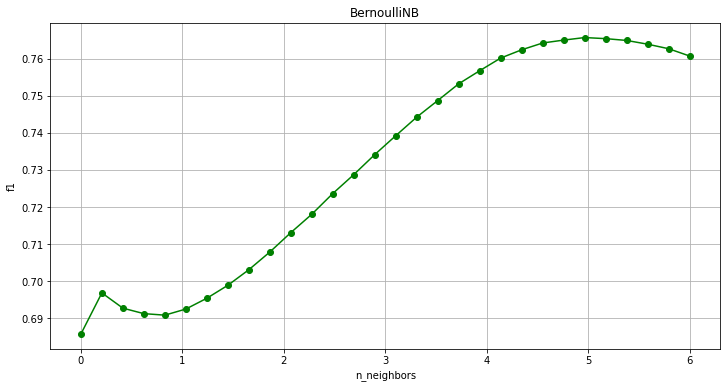

In [ ]:
# Строим график зависимости качества от числа соседей
# замечание: результаты обучения хранятся в атрибуте cv_results_ объекта gs
grid_plot(grid['alpha'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'BernoulliNB')

## Фильтруем самые частотные

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
freq = get_top_n_words(df_test[3], 50)

In [ ]:
freq = [i[0] for i in freq]

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopWords+freq+list(ENGLISH_STOP_WORDS), ngram_range=(1, 2)).fit(df[3])

X_train_vectors = vectorizer.transform(df_train[3])
X_test_vectors = vectorizer.transform(df_test[3])

In [ ]:
clf = BernoulliNB(alpha=0.5).fit(X_train_vectors, df_train[4])

In [ ]:
show_top(clf, vectorizer, 20)

pos: бля такое болит о_о время люблю новый жаль плохо хочется год делать дома спать знаю буду вообще почему могу блин
neg: нам такая такие утро могу год почему дома dd новый ахаха время пока ахах знаю вообще буду всем люблю спасибо


In [ ]:
# ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB

from sklearn.model_selection import GridSearchCV

alg = BernoulliNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),}

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1, scoring = 'f1')
gs.fit(X_train_vectors, df_train[4])
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   37.6s finished


({'alpha': 2.689655172413793}, 0.7613353634780609)

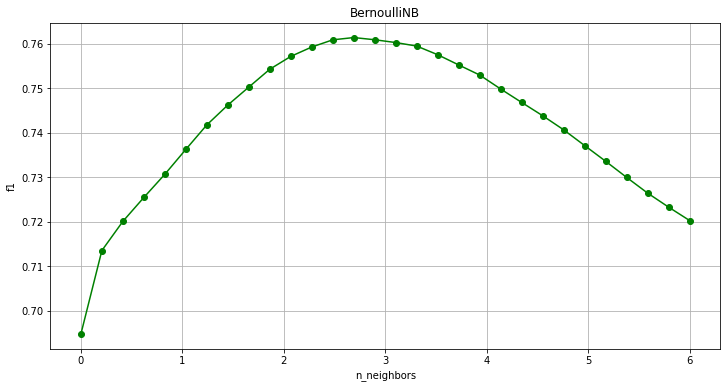

In [ ]:
# Строим график зависимости качества от числа соседей
# замечание: результаты обучения хранятся в атрибуте cv_results_ объекта gs
grid_plot(grid['alpha'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'BernoulliNB')

In [ ]:
stopWords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stem = SnowballStemmer("russian")

In [ ]:
def preprocess(doc):
    doc = doc.split()
    doc = [stem.stem(word) for word in doc]
    doc = ' '.join(doc)
    return doc

df[3] = df[3].map(preprocess)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,413686280438829056,1387465469,Do_Or_Die_xxx,RT @MO3GOBbIHOC: @Do_Or_Die_xxx уеб е с:,0,0,1,0,4290,362,256,0
1,411150298346831872,1386860844,evilRaymond,@mark_oliver_mew пот поищу. а вообщ мен больш ...,1,0,0,0,12238,192,154,2
2,411173655155322880,1386866413,skynettt,"@InspiredSasha ну, как в 1307 год в этот ден т...",1,0,0,0,10254,178,71,5
3,415132785766973441,1387810343,EpifanovaVE,"@freiner7 я не хоч завтр дежурить, перед ингли...",0,0,0,0,432,18,28,0
4,417315283083067392,1388330691,worthless_loser,попа на сам стремн момент матриц ну почемуууу ...,0,0,0,0,3854,57,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...
226829,409334579380903936,1386427943,alexdolgopoly,@FoolsNobodys там к нем провод подход электрич...,1,0,0,0,474,17,32,0
226830,410722098198622208,1386758753,Greatest_Mess,@_gotta_be_u_ дочита -расскажешь) может я тож ...,1,0,0,0,11257,456,387,6
226831,412007215600795648,1387065149,YiffyWolfy,эпик фейл эт ноч объявля потер девствен вайлет...,0,0,0,0,29431,553,260,11
226832,411419591873945600,1386925049,mariiish_kishmi,@kasimov_d_n вот как вы можете??!! я ж не виде...,0,0,0,0,2228,117,85,0
